# GloVe Testbook
### Step 1 - load data & helper functions


In [1]:
import torch
import torch.nn as nn
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

/home/cas/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [135]:
# path to dataset
DATAPATH = 'smallchungus.csv' #big_chungus.xlsx balanced3360.csv smallchungus.csv
# device
device = 'cpu'

In [11]:
# takes in string & returns a cleaned string of all non-stop-words
def preprocess(text, lemmatizer = WordNetLemmatizer()):
    sw = set(stopwords.words('english'))
    text = re.sub(r'[^\w\s]', '', text).lower()
    s = ""
    for word in text.split():
        if word not in sw:
                s += (lemmatizer.lemmatize(word) + " ")
    return s


In [18]:
tokenizer = get_tokenizer("basic_english")
max_words = 20
embed_len=300
global_vectors = GloVe(name='840B', dim=embed_len)

In [24]:
# takes string, return 6000 dim GloVe vector
def to_vector(s):
    X = tokenizer(s)
    # fill / cut tokens to max size
    if len(X) < max_words:
        X = X+[""]*(max_words-len(X))
    else:
        X = X[:max_words]

    X_tensor = torch.zeros(1, max_words, embed_len)
    for i, j in enumerate(X):
        X_tensor[0][i] = global_vectors.get_vecs_by_tokens(j)
    return(X_tensor.reshape(1, -1))

In [48]:
x = to_vector("test")
y = to_vector("vetor")
Z = torch.cat((x, y), 1)
Z.shape

torch.Size([1, 12000])

### Step 2 - define pytorch custom dataset class

In [49]:
# config

# custom dataset class
class StanceDataset(Dataset):
    def __init__(self, stance_df,  val_split=False):
        """  Initalizes vectorizers, defines train/test splits
        Args:
            stance_df (pandas.DataFrame): the dataset
        """
        self.df = stance_df
        
        # splits (train, test, validation) 80/20 
        self.train, self.test = train_test_split(self.df, test_size=0.2, shuffle=True)
        if val_split == True:   
            # 50/50 val/test
            self.test, self.val = train_test_split(self.test, test_size=0.5, shuffle=False)
            self.val_len = len(self.val)
        # split sizes
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        
        self._lookup_dict = {'train': (self.train, self.train_len),
                             'test': (self.test, self.test_len)}
        if val_split == True:
            self._lookup_dict.update({'val': (self.val, self.val_len)})

        self.set_split('train')


    def set_split(self, split='train'):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """
        Args:
            index (int): index to current data point
        Returns:
            dictionary holding tensor data point feature (x_data) and skalar tensor label (y_data)
        """
        
        # get text values from current row
        row = (self._target_df.iloc[index])
        claim = [row['head']]
        body = [row['body']]

        # create 6k vector for each
        claim = to_vector(preprocess(claim[0]))
        body = to_vector(preprocess(body[0]))
        
        # 12k combined input vector
        x_data = torch.cat((claim, body), 1)

        # get stance & convert to tensor
        y_data = row['Stance']
        stance_map = {
            "agree": 0,
            "disagree": 1,
            "discuss": 2,
            "unrelated": 3
        }
        y_data = torch.tensor(stance_map[y_data])
        return {'x_data': x_data,
                'y_target': y_data}

In [136]:
def load_dataset(excel=True):
    """
    applies dataset class to dataset located at DATAPATH
    args:
        excel (bool): default true for .xlsx, else set false
    """
    print('loading dataset...')
    if excel == True:
        df = pd.read_excel(
            DATAPATH, 
            index_col=None, 
            header=0   
        )
    else:
        df = pd.read_csv(
            DATAPATH, 
            index_col=None,
            header=0   
        )
    print('loaded!')
    
    dataset = StanceDataset(df, val_split=False)
    return dataset

In [137]:
data = load_dataset(excel=False)

loading dataset...
loaded!


In [138]:
"""
Test block for getitem. This is what the training loop will call
"""

data.set_split('train')
print("should be the lenght of train split: ", len(data._target_df))

d = data.__getitem__(1)
print(d['x_data'])
print(d['y_target'])
print(len((d['x_data'])[0]))

should be the lenght of train split:  25360
tensor([[-0.3264, -0.0474, -0.3089,  ..., -0.2004,  0.2527, -0.2000]])
tensor(3)
12000


### Weighted Sampler

{'unrelated': 14669, 'discuss': 7114, 'agree': 2924, 'disagree': 653}


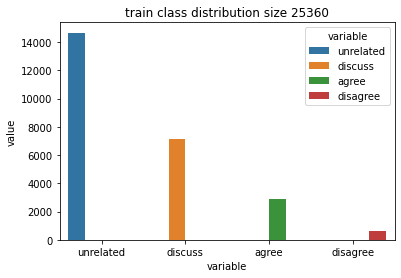

In [139]:
# distribution of labels (class distribution)
def dist_of(df):
    class_distribution = (pd.value_counts(df['Stance'])).to_dict()
    print(class_distribution)
    sns.barplot(data = pd.DataFrame.from_dict([class_distribution]).melt(), x = "variable", y="value", hue="variable").set_title(f'train class distribution size {len(df)}')

dist_of(data._target_df)

In [140]:
def sample(d):
    class_count = dict(pd.value_counts(d['Stance']))
    print(class_count)
    stance_map = {
        "agree": 0,
        "disagree": 1,
        "discuss": 2,
        "unrelated": 3
    }
    # fit the class count to sequence agree, disagree, discuss, unrelated
    cc = [0, 0, 0, 0]
    for key in class_count:
        cc[stance_map[key]] = class_count[key]

    weight = 1./torch.tensor(cc, dtype=torch.float).to(device)
    print(weight)
    
    # create array with weight for each data point
    target_list = [stance_map[(d.iloc[i]['Stance'])] for i in range(len(d))]
    samples_weight = torch.tensor([weight[t] for t in target_list]).to(device)

    weighted_sampler = WeightedRandomSampler(
        weights=samples_weight,
        num_samples=len(samples_weight),
        replacement=True
    )
    return weighted_sampler, weight

train_sampler, train_weights = sample(data._target_df)

{'unrelated': 14669, 'discuss': 7114, 'agree': 2924, 'disagree': 653}
tensor([3.4200e-04, 1.5314e-03, 1.4057e-04, 6.8171e-05])


### Step 3 - Define model & training

In [141]:
# hyperparameters
in_dim = 12000
hidden_dim = 120
out_dim = 4
epochs = 30 # 45
batch = 32
lr = 0.001

In [142]:
# re-usable way to create dataloader
def make_batches(dataset, batch_size, shuffle=True, drop_last=True, sampler=None):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last, sampler=sampler)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [143]:
# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()

        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x).squeeze()
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NN(in_dim, hidden_dim, out_dim).to(device)

criterion = nn.CrossEntropyLoss(weight=train_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [144]:
"""
training loop
"""
loss_vals=  {}
loss_vals['train'] = []
loss_vals['test'] = []


for epoch in range(epochs):

    # setup
    data.set_split('train')
    train_loader = make_batches(data, batch, shuffle=False, sampler=train_sampler)

    running_loss = 0.
    last_loss = 0.
    epoch_loss = []

    # enumerate to track the batch index and do some intra-epoch reporting
    for i, sample in enumerate(train_loader):
        # zero gradients each batch
        optimizer.zero_grad()
        
        inputs = ((sample)['x_data']).float()
        labels = sample['y_target']

        # predict for batch
        outputs = model(inputs)

        # compute loss and gradients
        loss = criterion(outputs, labels)
        epoch_loss.append(loss.item())
        loss.backward()

        # adjust weights
        optimizer.step()

        # report
        running_loss += loss.item()
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('Epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.
        
    # append avg loss per epoch to loss vals
    loss_vals['train'].append(sum(epoch_loss)/len(epoch_loss))

Epoch 1 batch 1 loss: 0.001409625768661499
Epoch 1 batch 101 loss: 0.05786837814748287
Epoch 1 batch 201 loss: 0.041535370126366614
Epoch 1 batch 301 loss: 0.03347835573554039
Epoch 1 batch 401 loss: 0.029320901677012443
Epoch 1 batch 501 loss: 0.02471588784456253
Epoch 1 batch 601 loss: 0.021759502314031124
Epoch 1 batch 701 loss: 0.019405873280018568
Epoch 2 batch 1 loss: 0.00018100549280643464
Epoch 2 batch 101 loss: 0.015615786446258426
Epoch 2 batch 201 loss: 0.014142424799501896
Epoch 2 batch 301 loss: 0.0129294752497226
Epoch 2 batch 401 loss: 0.01362232043594122
Epoch 2 batch 501 loss: 0.011401698114350439
Epoch 2 batch 601 loss: 0.010481084557250142
Epoch 2 batch 701 loss: 0.010047006700187922
Epoch 3 batch 1 loss: 2.255670726299286e-05
Epoch 3 batch 101 loss: 0.007959770509507507
Epoch 3 batch 201 loss: 0.00783276885561645
Epoch 3 batch 301 loss: 0.008422155209816993
Epoch 3 batch 401 loss: 0.007357230896130204
Epoch 3 batch 501 loss: 0.008149660000577569
Epoch 3 batch 601 lo

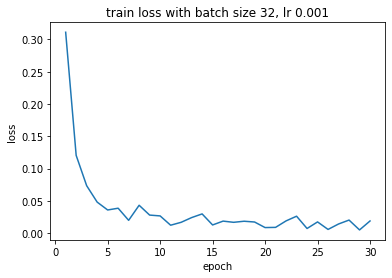

In [145]:
# plot loss once finished
def my_plot(epochs, loss):
    plt.plot(epochs, loss)
    plt.title(f'train loss with batch size {batch}, lr {lr}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
# plot loss when finished
my_plot(np.linspace(1, epochs, epochs).astype(int), loss_vals['train'])

In [146]:
# set test split
data.set_split('test')
test_loader = make_batches(data, batch)

# accuracy
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    y_pred = []
    y_true = []
    for i, sample in enumerate(test_loader):
        
        if batch == 1:
            inputs = (sample['x_data'])[0].float()
        else:
            inputs = ((sample)['x_data']).float()
        labels = sample['y_target']
        
        
        # test the trained model
        outputs = model(inputs)
        
        # value, index
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

        n_samples += labels.shape[0] # gives us n of samples of current batch
        n_correct += (predictions == labels).sum().item()

    
    # accuracy in percent
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')


accuracy = 93.93939393939394


In [147]:
from sklearn.metrics import classification_report
 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       754
           1       0.76      0.78      0.77       187
           2       0.93      0.95      0.94      1793
           3       0.97      0.95      0.96      3602

    accuracy                           0.94      6336
   macro avg       0.88      0.89      0.89      6336
weighted avg       0.94      0.94      0.94      6336



In [162]:
# save the model
torch.save(model.state_dict(), "./kowalsky_90_weighted_bigram.pth")

[[0.85175879 0.08376963 0.01911524 0.00710631]
 [0.0201005  0.76439791 0.0076461  0.00312678]
 [0.04145729 0.05235602 0.9273621  0.01478113]
 [0.08668342 0.09947644 0.04587657 0.97498579]]


<AxesSubplot:title={'center':'cf matrix of testadata size 6340, lr: 0.001, batches: 32, epochs: 30'}>

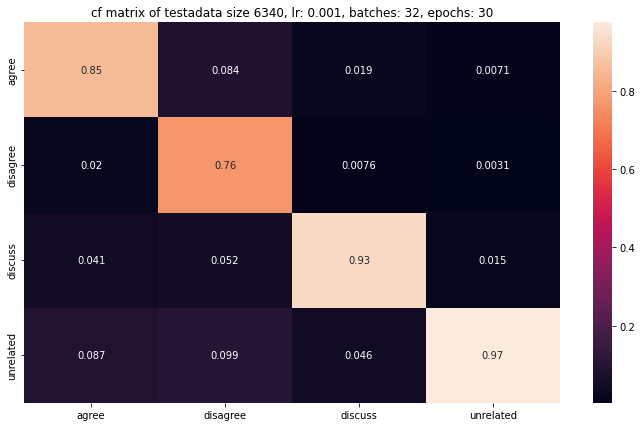

In [148]:
# confusion matrix
classes = ['agree', 'disagree', 'discuss', 'unrelated']

# Build confusion matrix (normalized as precision)
cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred')
# precision, is in a sense correctness, and recall is completeness.

print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title(f'cf matrix of testadata size {len(data._target_df)}, lr: {lr}, batches: {batch}, epochs: {epochs}')
sns.heatmap(df_cm, annot=True)

In [179]:
agree_row = (data.df).iloc[1]
disagree_row = (data.df).iloc[4434]

agree_head = agree_row['head']
agree_body = agree_row['body']

disagree_head = disagree_row['head']
disagree_body = disagree_row['body']

print(f"{agree_head} \n---\nshould agree with\n---\n{agree_body}")

Who Should Play Steve Jobs Now That Christian Bale Quit? 
---
should agree with
---
Christian Bale will not be starring as Steve Jobs in Aaron Sorkin's upcoming Steve Jobs biopic, according to The Hollywood Reporter. The actor has reportedly decided that he was "not right for the part," deciding to withdraw from the film.

Bale was announced as the star of the film just last week, with Sorkin saying that Christian Bale was "the best actor in a certain age range" to play Jobs, and that he had agreed to the part without an audition.

Set to be directed by Danny Boyle, who also directed the Oscar-winning hit Slumdog Millionaire, the upcoming Steve Jobs project focuses on three continuous 30-minute scenes that depict three of Apple's product launches.

While it is now unclear who will play Steve Jobs in the movie, Seth Rogen is reportedly in talks to play Apple co-founder Steve Wozniak, and Jessica Chastain, from The Help, is also being considered for an unspecified role in the film. Leona

In [183]:
print(f"{disagree_head} \n---\nshould disagree with\n---\n{disagree_body[:600]} ...")

NASA Confirms Earth Will Experience 6 Days of Total Darkness in December 2014! 
---
should disagree with
---
It may feel like winter is slowly squeezing all the sunlight out of your day, but if you see any news stories claiming Earth is headed for "Six Days of Total Darkness" then don't start stocking up on the tins of beans and torches just yet.

"Satirical news site" Huzlers.com has been spreading this fake story far and wide on the web this week, taking in numerous Facebook and Twitter users and encouraging them to post about what they're going to be up to during the six days of darkness.

The story on the vaguely official looking website titled "Nasa Confirms Earth Will Experience 6 Days of Total ...


In [184]:
claim = to_vector(preprocess(agree_head))
body = to_vector(preprocess(agree_body))
        
# 12k combined input vector
x_data = torch.cat((claim, body), 1)

# demo predict
pred = model(x_data)
pred_out, pred_idx = torch.max(pred, 0)

print(pred_out, pred_idx)
classes = ['agree', 'disagree', 'discuss', 'unrelated']
stance = classes[(pred_idx.data).numpy()]

print(stance)

tensor(10.2128, grad_fn=<MaxBackward0>) tensor(0)
agree
